In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from pyepo.model.grb import tspDFJModel, tspGGModel
# set solver
optmodel = tspDFJModel(num_node)
optmodel_gg = tspGGModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-09
Obj: 58.7221
0 -> 10 -> 16 -> 5 -> 3 -> 17 -> 1 -> 4 -> 12 -> 14 -> 9 -> 11 -> 2 -> 7 -> 18 -> 13 -> 6 -> 19 -> 8 -> 15 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 160.44it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.02it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 163.28it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    # draw plot
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.title("Learning Curve on Test Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 1e-2
num_epochs = 300
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train_cost:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
              format(epoch, loss.item(), regret_trn*100, regret_val*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  71.7208, Train Regret: 185.4567%, Val Regret: 195.2715%
Epoch  20, Loss:  64.2362, Train Regret:  36.7436%, Val Regret:  43.0514%
Epoch  40, Loss:  44.3086, Train Regret:  27.3030%, Val Regret:  30.7645%
Epoch  60, Loss:  34.3119, Train Regret:  23.8441%, Val Regret:  27.4964%
Epoch  80, Loss:  23.1189, Train Regret:  22.9252%, Val Regret:  25.4494%
Epoch 100, Loss:  15.6777, Train Regret:  21.4157%, Val Regret:  24.3243%
Epoch 120, Loss:  12.6534, Train Regret:  20.2237%, Val Regret:  23.2376%
Epoch 140, Loss:  10.7017, Train Regret:  19.3994%, Val Regret:  22.4345%
Epoch 160, Loss:   5.7690, Train Regret:  18.7920%, Val Regret:  21.4155%
Epoch 180, Loss:  13.2600, Train Regret:  18.6366%, Val Regret:  20.5089%
Epoch 200, Loss:  13.9739, Train Regret:  17.6471%, Val Regret:  19.6377%
Epoch 220, Loss:  10.2036, Train Regret:  16.7775%, Val Regret:  19.0103%
Epoch 240, Loss:   6.2330, Train Regret:  16.7777%, Val Regret:  18.4957%
Epoch 260, Loss:   5.4540, Train Regre

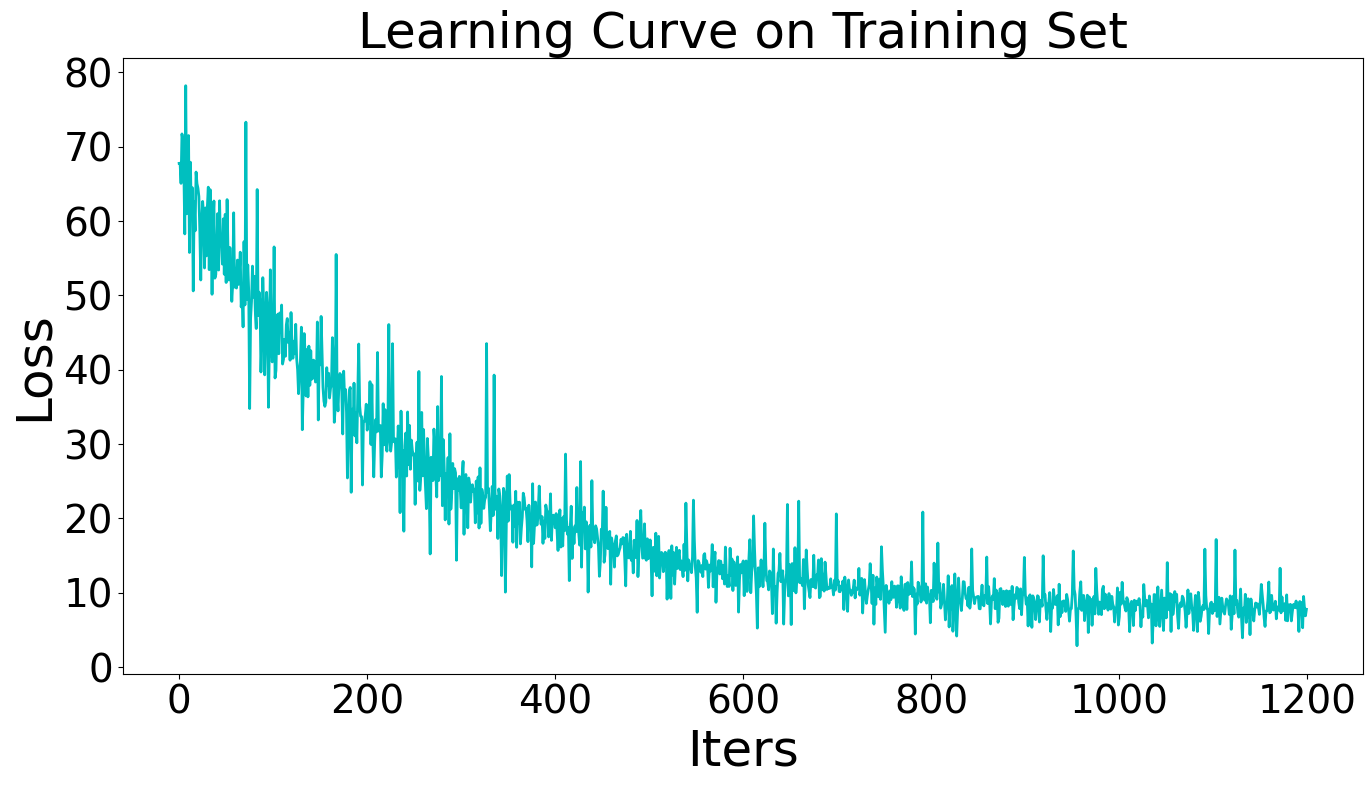

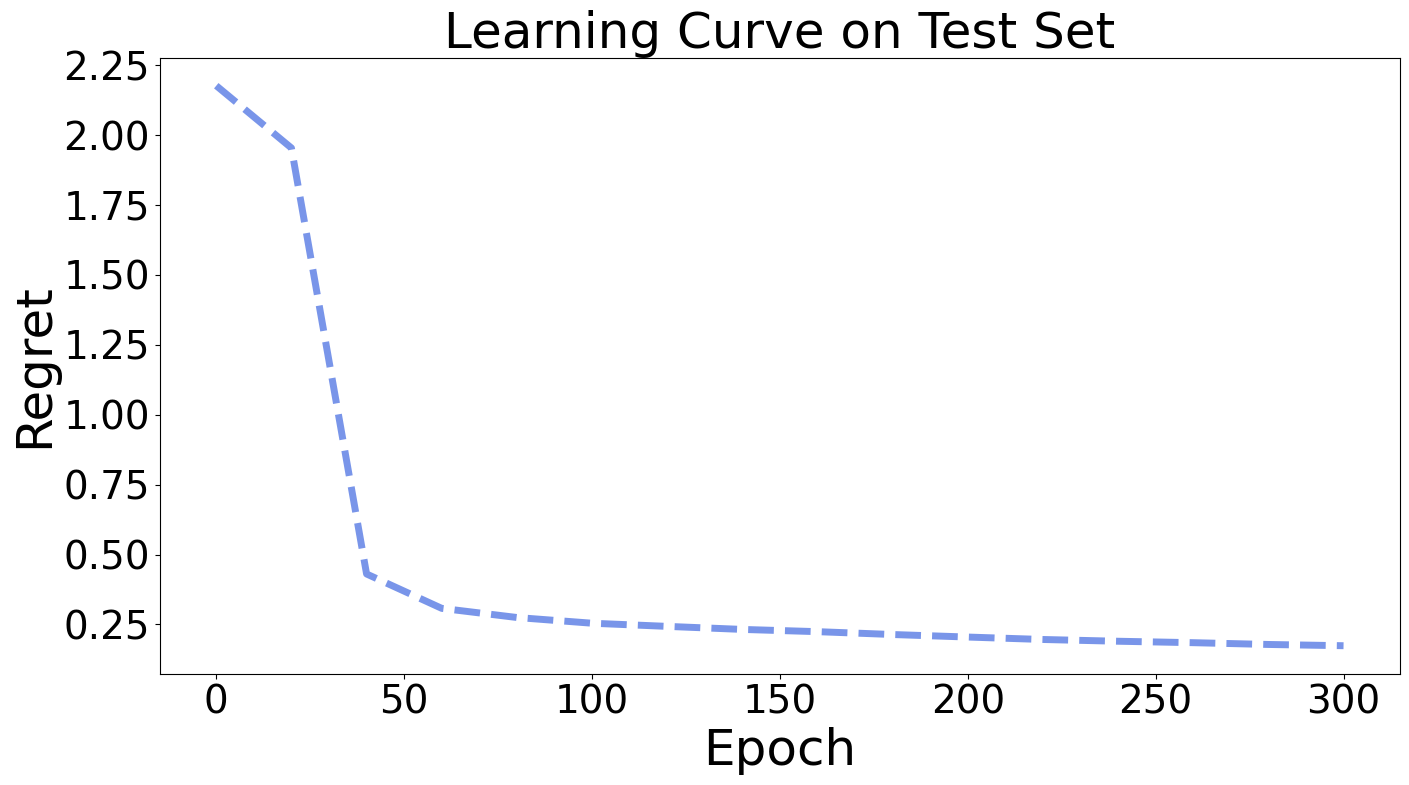

In [14]:
plot(loss_log, regret_log, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel_gg)

In [17]:
lr = 1e-2
num_epochs = 300
log_step = 20
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9128, Train Regret: 182.5377%, Val Regret: 183.5521%
Epoch  20, Loss:  -0.9985, Train Regret:  33.4365%, Val Regret:  52.3844%
Epoch  40, Loss:  -0.9997, Train Regret:  21.8273%, Val Regret:  39.3379%
Epoch  60, Loss:  -1.0000, Train Regret:  18.9351%, Val Regret:  36.1598%
Epoch  80, Loss:  -1.0000, Train Regret:  16.5889%, Val Regret:  34.4806%
Epoch 100, Loss:  -1.0000, Train Regret:  14.9845%, Val Regret:  33.5772%
Epoch 120, Loss:  -1.0000, Train Regret:  13.9231%, Val Regret:  32.7695%
Epoch 140, Loss:  -1.0000, Train Regret:  12.3633%, Val Regret:  32.0886%
Epoch 160, Loss:  -1.0000, Train Regret:  12.4782%, Val Regret:  32.0361%
Epoch 180, Loss:  -1.0000, Train Regret:  10.9503%, Val Regret:  31.9129%
Epoch 200, Loss:  -1.0000, Train Regret:  10.0930%, Val Regret:  31.7380%
Epoch 220, Loss:  -1.0000, Train Regret:   9.1132%, Val Regret:  31.7632%
Epoch 240, Loss:  -1.0000, Train Regret:   8.9304%, Val Regret:  31.7485%
Epoch 260, Loss:  -1.0000, Train Regre

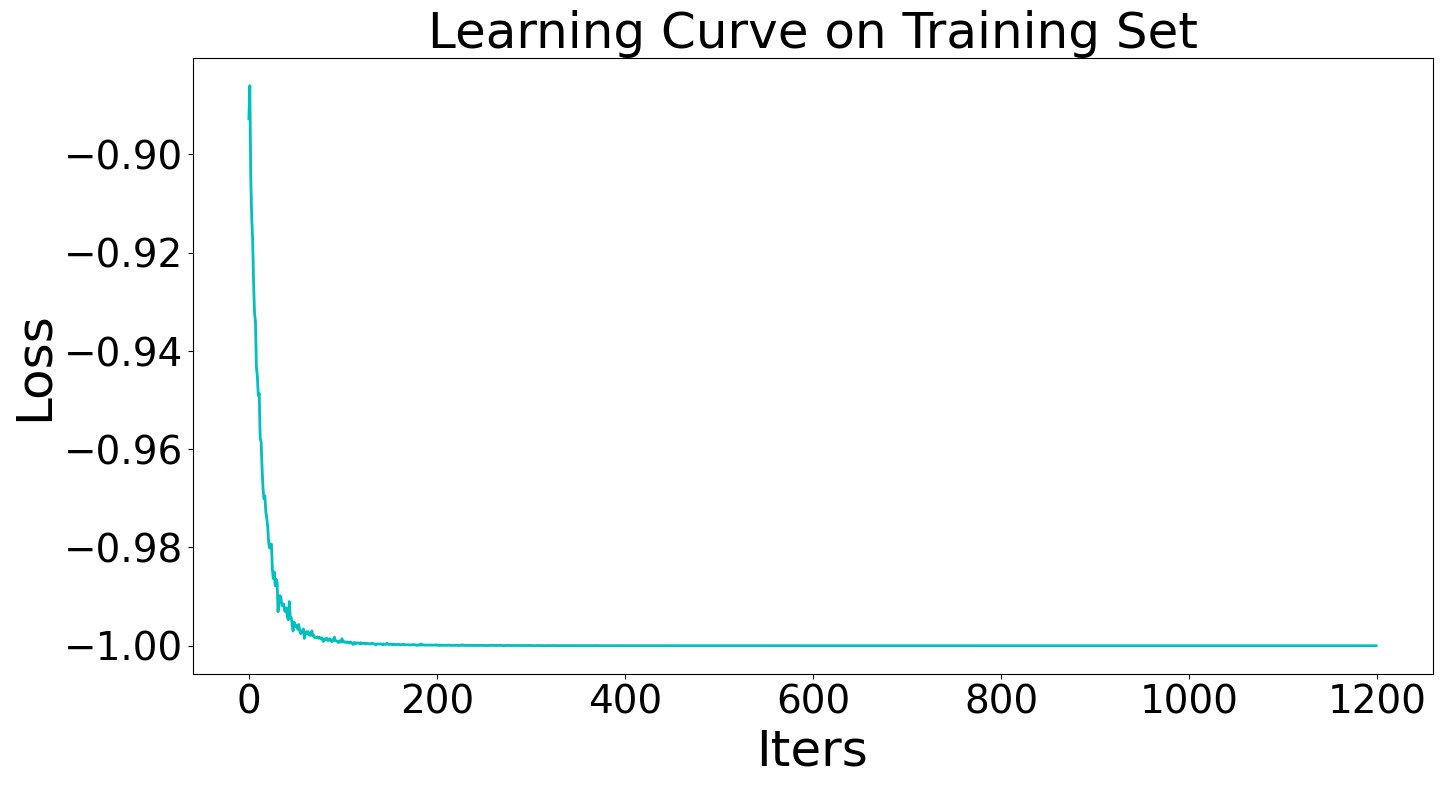

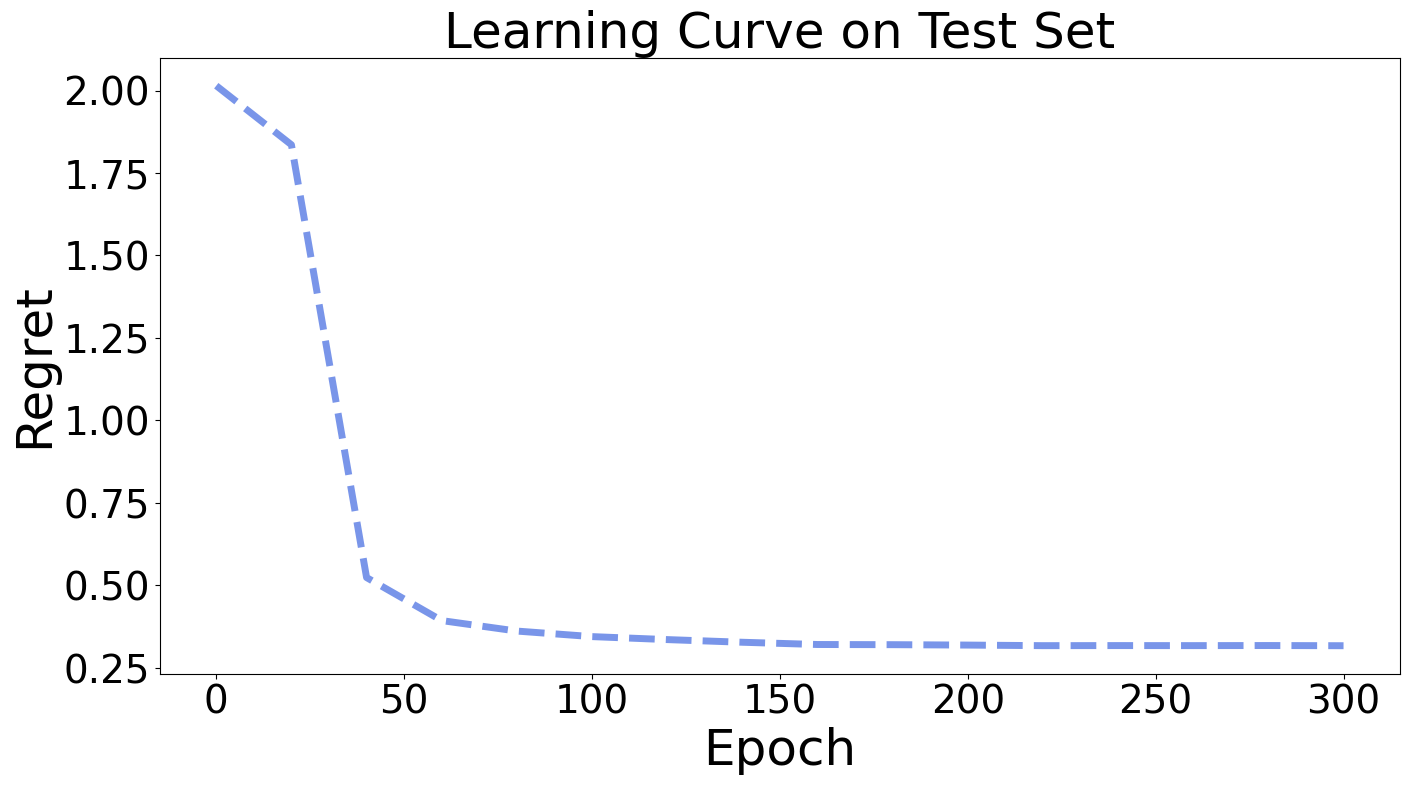

In [18]:
plot(loss_log, regret_log, num_epochs, log_step)

### Sampling Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel_gg, n_samples=100)

In [21]:
lr = 1e-2
num_epochs = 300
log_step = 20
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.1668, Train Regret: 177.2625%, Val Regret: 186.6683%
Epoch  20, Loss:  -0.7188, Train Regret:  18.0835%, Val Regret:  32.2879%
Epoch  40, Loss:  -0.8235, Train Regret:  14.7646%, Val Regret:  23.2381%
Epoch  60, Loss:  -0.8275, Train Regret:  15.8707%, Val Regret:  23.5641%
Epoch  80, Loss:  -0.8138, Train Regret:  14.1931%, Val Regret:  23.4039%
Epoch 100, Loss:  -0.8179, Train Regret:  13.7184%, Val Regret:  21.9282%
Epoch 120, Loss:  -0.8185, Train Regret:  13.1080%, Val Regret:  22.2188%
Epoch 140, Loss:  -0.8058, Train Regret:  12.4183%, Val Regret:  23.0096%
Epoch 160, Loss:  -0.8447, Train Regret:  14.0937%, Val Regret:  22.9969%
Epoch 180, Loss:  -0.7996, Train Regret:  13.2299%, Val Regret:  21.5154%
Epoch 200, Loss:  -0.8158, Train Regret:  13.2824%, Val Regret:  22.8271%
Epoch 220, Loss:  -0.8135, Train Regret:  13.8084%, Val Regret:  22.6649%
Epoch 240, Loss:  -0.8100, Train Regret:  12.1015%, Val Regret:  22.0028%
Epoch 260, Loss:  -0.8166, Train Regre

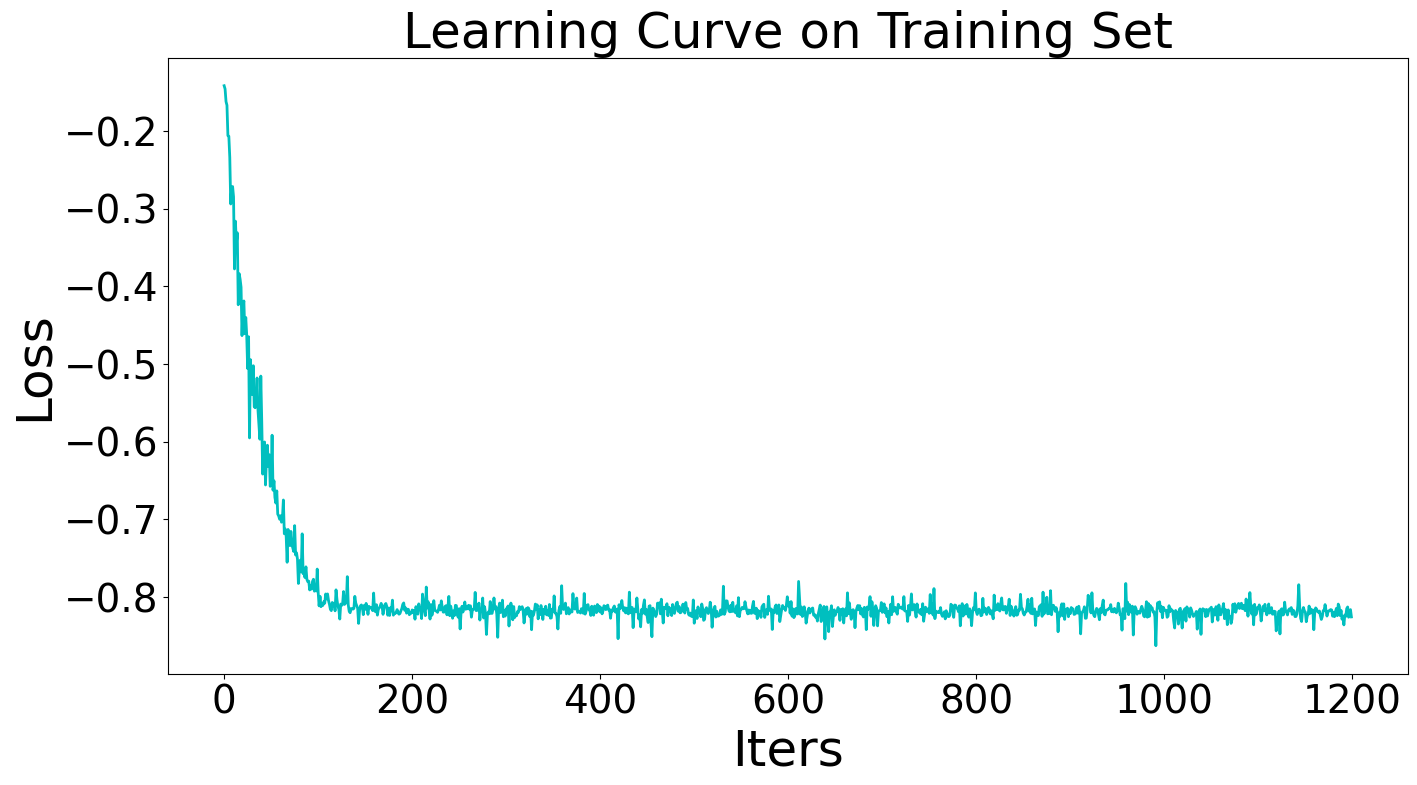

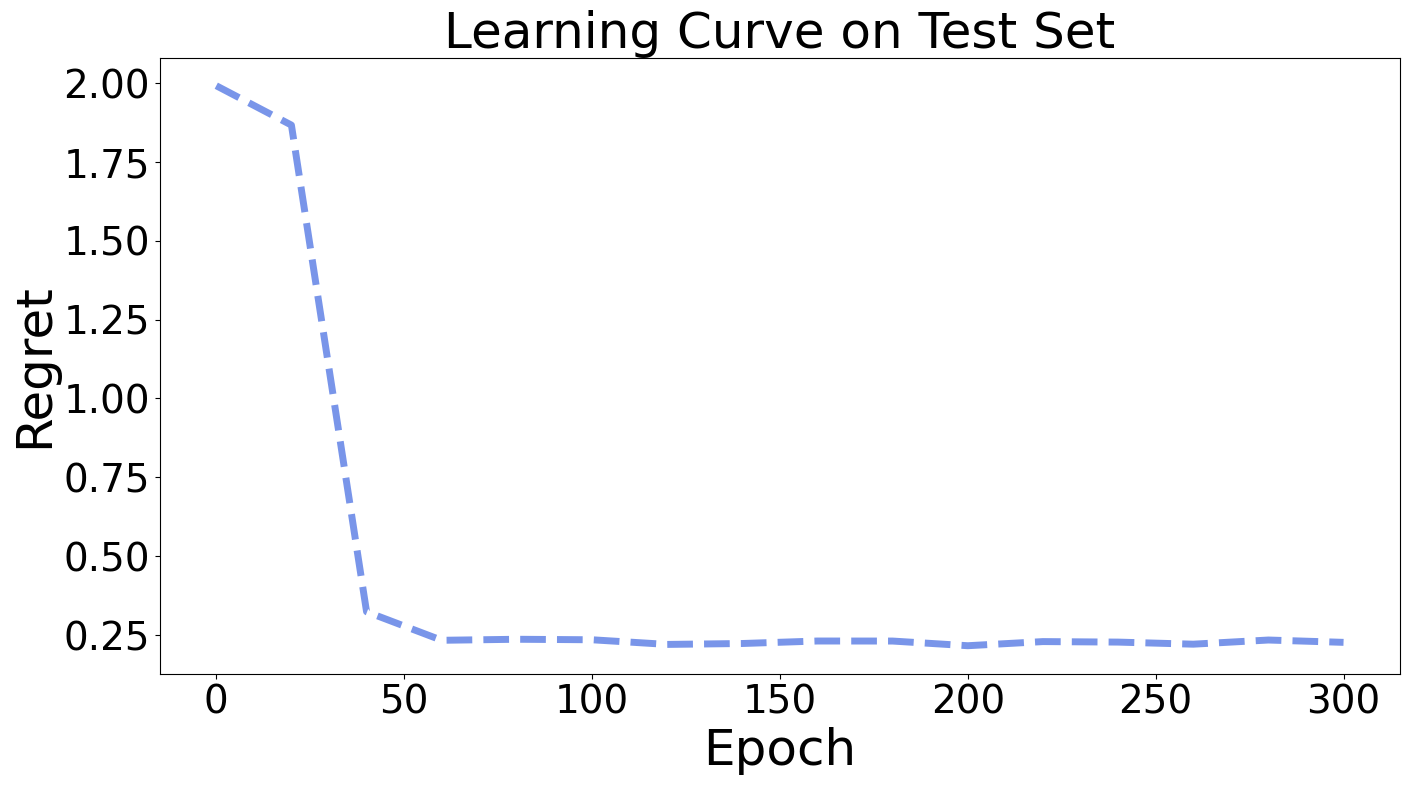

In [22]:
plot(loss_log, regret_log, num_epochs, log_step)

### PFYL 

In [23]:
# init model
reg = LinearRegression()

In [24]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0)

Num of cores: 1


In [25]:
lr = 1e-2
num_epochs = 300
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  22.6111, Train Regret: 166.7999%, Val Regret: 167.7048%
Epoch  20, Loss:  15.6667, Train Regret:  11.6284%, Val Regret:  23.3502%
Epoch  40, Loss:   8.4444, Train Regret:   7.0070%, Val Regret:  17.7025%
Epoch  60, Loss:   9.3889, Train Regret:   5.3359%, Val Regret:  16.1929%
Epoch  80, Loss:   6.2222, Train Regret:   3.7153%, Val Regret:  16.3781%
Epoch 100, Loss:   7.2222, Train Regret:   3.5148%, Val Regret:  15.9610%
Epoch 120, Loss:   7.7222, Train Regret:   2.4701%, Val Regret:  15.6724%
Epoch 140, Loss:   5.3333, Train Regret:   2.1387%, Val Regret:  15.8033%
Epoch 160, Loss:   7.9444, Train Regret:   2.5289%, Val Regret:  15.8062%
Epoch 180, Loss:   4.5000, Train Regret:   2.0565%, Val Regret:  15.6689%
Epoch 200, Loss:   7.0000, Train Regret:   1.7320%, Val Regret:  15.7420%
Epoch 220, Loss:   5.5000, Train Regret:   1.5867%, Val Regret:  15.7046%
Epoch 240, Loss:   3.5556, Train Regret:   1.1391%, Val Regret:  15.9849%
Epoch 260, Loss:   4.4444, Train Regre

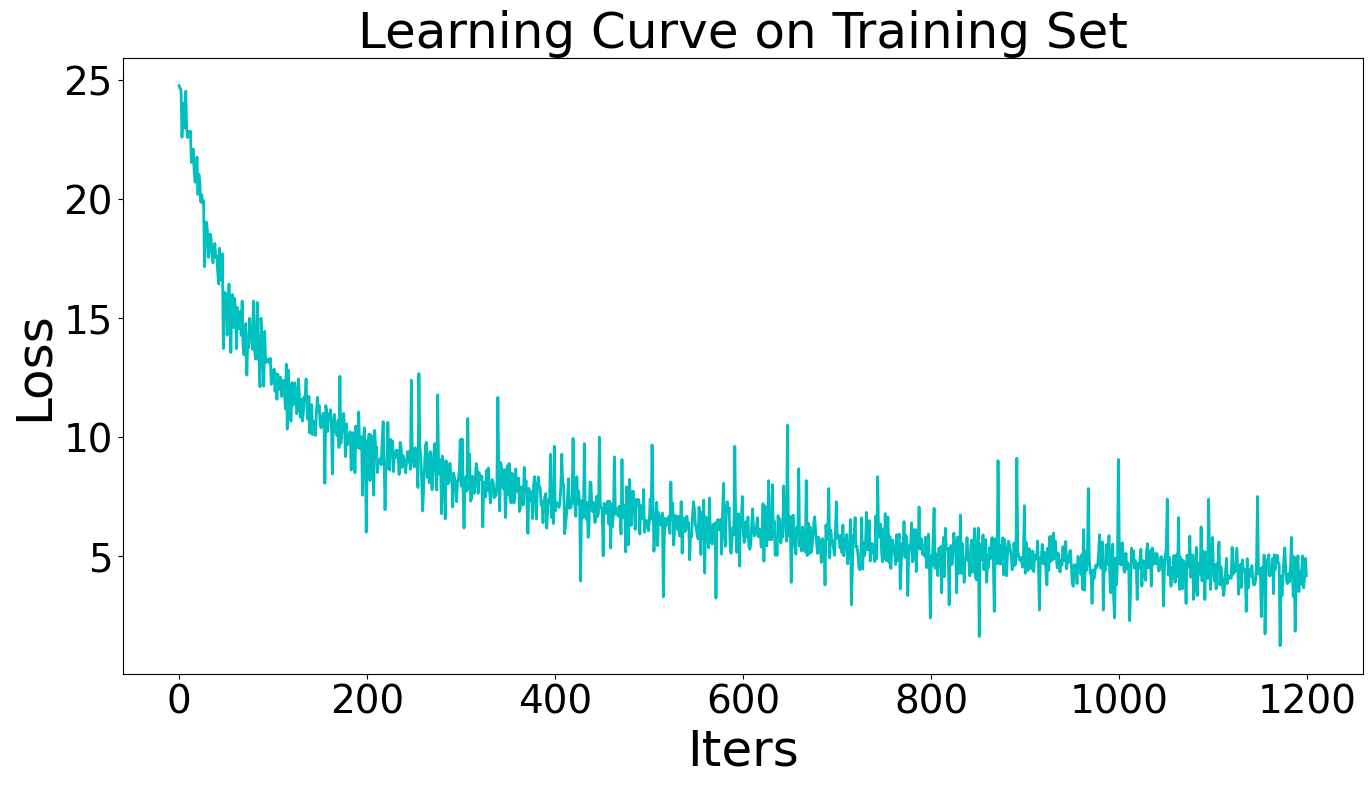

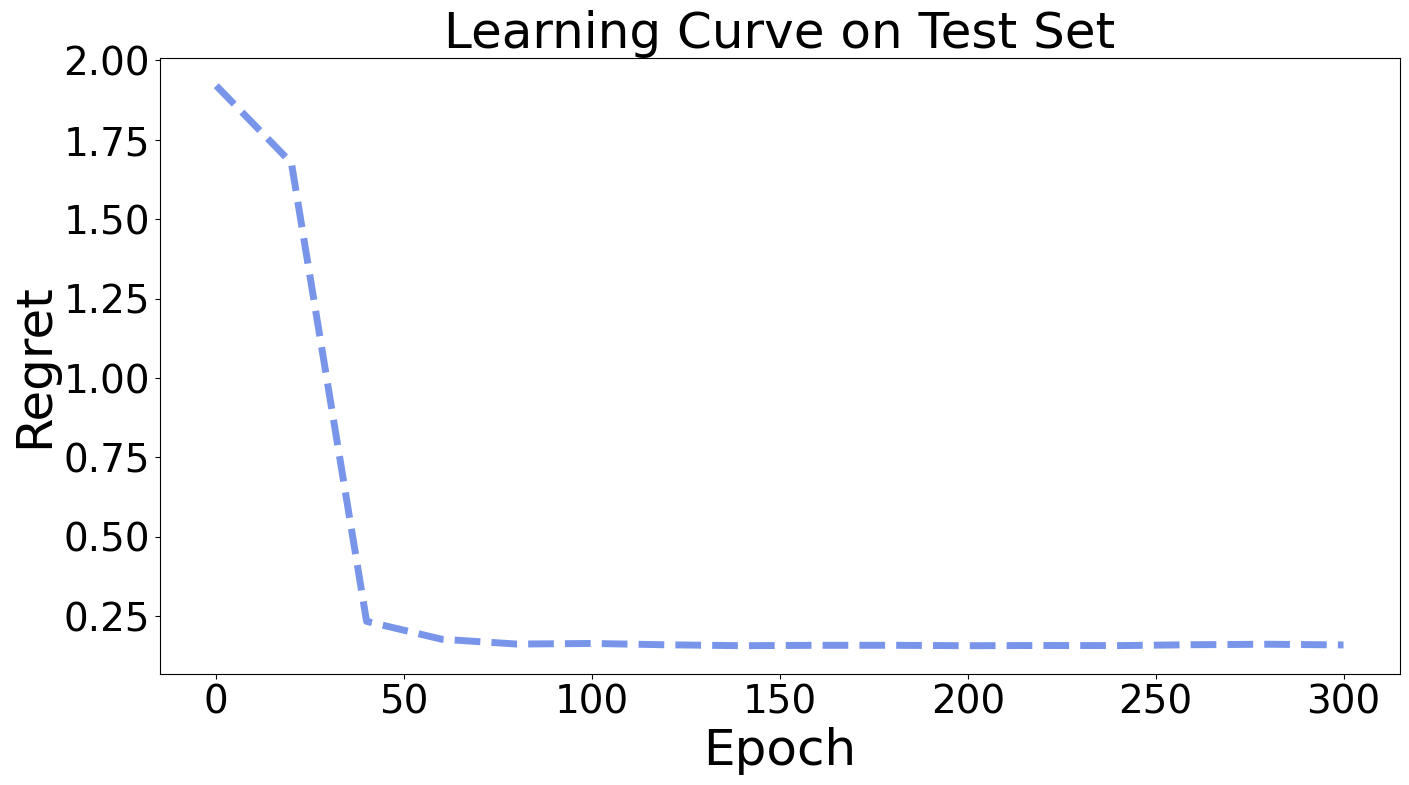

In [26]:
plot(loss_log, regret_log, num_epochs, log_step)